# Main objective: Investigating the effects of hormone treatment on cancer-recurrence-free survival time using survival analysis

I use the *lifelines* package for survival analysis.

## Installing and importing the necessary libraries 

In [300]:
!pip install lifelines

Defaulting to user installation because normal site-packages is not writeable
Looking in links: /usr/share/pip-wheels


In [301]:
!pip install matplotlib

Defaulting to user installation because normal site-packages is not writeable
Looking in links: /usr/share/pip-wheels


In [234]:
import pandas as pd
from lifelines import KaplanMeierFitter, CoxPHFitter
import matplotlib.pyplot as plt

# Description of the data

Here I analyze the German Breast Cancer Study Group 2 (GBSG2) dataset, which is publicly available. It contains the effects of hormone treatment on cancer-recurrence-free survival time. 

## References: 

1. https://paperswithcode.com/dataset/gbsg2
2. https://lifelines.readthedocs.io/en/latest/lifelines.datasets.html#lifelines.datasets.load_gbsg2
3. https://ascopubs.org/doi/10.1200/JCO.1994.12.10.2086?url_ver=Z39.88-2003&rfr_id=ori:rid:crossref.org&rfr_dat=cr_pub%20%200pubmed 

# Section 1: Loading and exploring the data 

In [275]:
# Loading the data from its online source  
url = "https://raw.githubusercontent.com/CamDavidsonPilon/lifelines/master/lifelines/datasets/gbsg2.csv"
df = pd.read_csv(url)
print(df.head(20))

   horTh  age menostat  tsize tgrade  pnodes  progrec  estrec  time  cens
0     no   70     Post     21     II       3       48      66  1814     1
1    yes   56     Post     12     II       7       61      77  2018     1
2    yes   58     Post     35     II       9       52     271   712     1
3    yes   59     Post     17     II       4       60      29  1807     1
4     no   73     Post     35     II       1       26      65   772     1
5     no   32      Pre     57    III      24        0      13   448     1
6    yes   59     Post      8     II       2      181       0  2172     0
7     no   65     Post     16     II       1      192      25  2161     0
8     no   80     Post     39     II      30        0      59   471     1
9     no   66     Post     18     II       7        0       3  2014     0
10   yes   68     Post     40     II       9       16      20   577     1
11   yes   71     Post     21     II       9        0       0   184     1
12   yes   59     Post     58     II  

Note that "cens" is the column of our interest, as it indicates whether cancer recurrence has happened (=1) or not (=0). The absence of cancer recurrence (i.e., event not happening) is equivalent to censoring.  

In [238]:
# Inspecting the data structure 
print("Size of the dataset (rows & columns):", df.shape)
print(df.info())
print('Summarizing the variation in recurrence of cancer time (in days):\n', df['time'].describe())

Size of the dataset (rows & columns): (686, 10)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 686 entries, 0 to 685
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   horTh     686 non-null    object
 1   age       686 non-null    int64 
 2   menostat  686 non-null    object
 3   tsize     686 non-null    int64 
 4   tgrade    686 non-null    object
 5   pnodes    686 non-null    int64 
 6   progrec   686 non-null    int64 
 7   estrec    686 non-null    int64 
 8   time      686 non-null    int64 
 9   cens      686 non-null    int64 
dtypes: int64(7), object(3)
memory usage: 53.7+ KB
None
Summarizing the variation in recurrence of cancer time (in days):
 count     686.000000
mean     1124.489796
std       642.791948
min         8.000000
25%       567.750000
50%      1084.000000
75%      1684.750000
max      2659.000000
Name: time, dtype: float64


There are no missing values in any of the columns. 

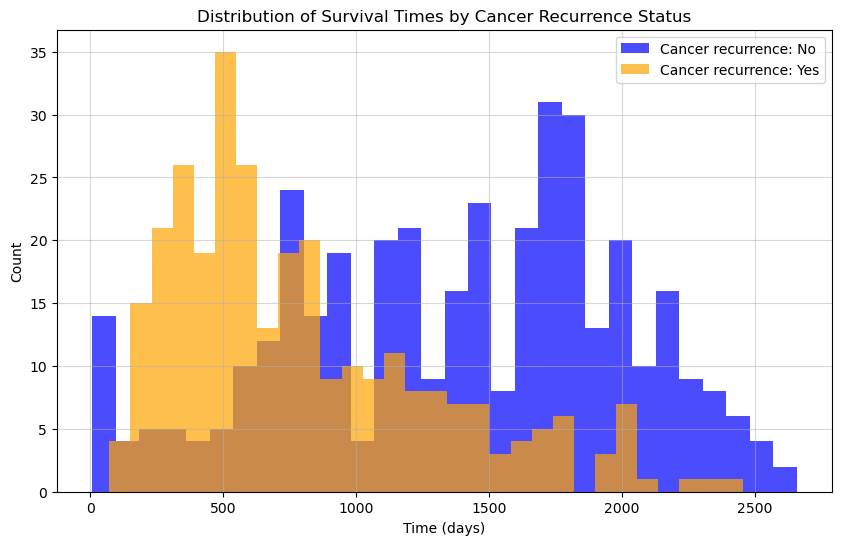

In [240]:
# Histogram showing the distribution of survival time by cancer recurrence status
plt.figure(figsize=(10, 6))
plt.hist(df[df['cens'] == 0]['time'], bins=30, alpha=0.7, label='Cancer recurrence: No', color='blue')
plt.hist(df[df['cens'] == 1]['time'], bins=30, alpha=0.7, label='Cancer recurrence: Yes', color='orange')
plt.title("Distribution of Survival Times by Cancer Recurrence Status")
plt.xlabel("Time (days)")
plt.ylabel("Count")
plt.legend(loc='upper right')
plt.grid(alpha=0.5)
plt.show()

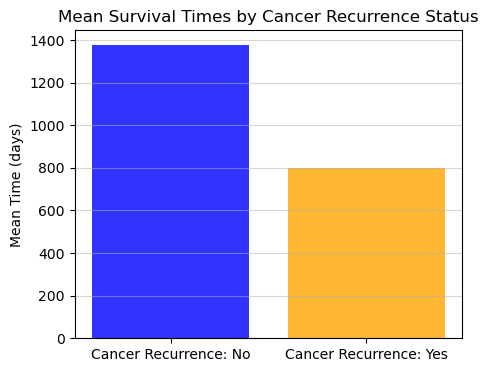

In [153]:
# Barplot for the mean survival time by cancer recurrence status
mean_times = df.groupby('cens')['time'].mean()
plt.figure(figsize=(5, 4))
plt.bar(x=['Cancer Recurrence: No', 'Cancer Recurrence: Yes'], height=mean_times, color=['blue', 'orange'], alpha=0.8)
plt.title("Mean Survival Times by Cancer Recurrence Status")
plt.ylabel("Mean Time (days)")
plt.grid(axis='y', alpha=0.5)
plt.show()

The mean number of days without cancer is shorter for those who had cancer recurrence. We will discover more details in the coming sections. 

# Section 2: The Kaplan-Meier Curve 

Next, to get a non-parametric visualization of the survival probability as a function of time, I use the Kaplan-Meier curve. (The details including the mathematical form of the survival function can be found in the Python [lifelines module](https://lifelines.readthedocs.io/en/latest/Survival%20analysis%20with%20lifelines.html).) 

Median survival time in days: 1807.0


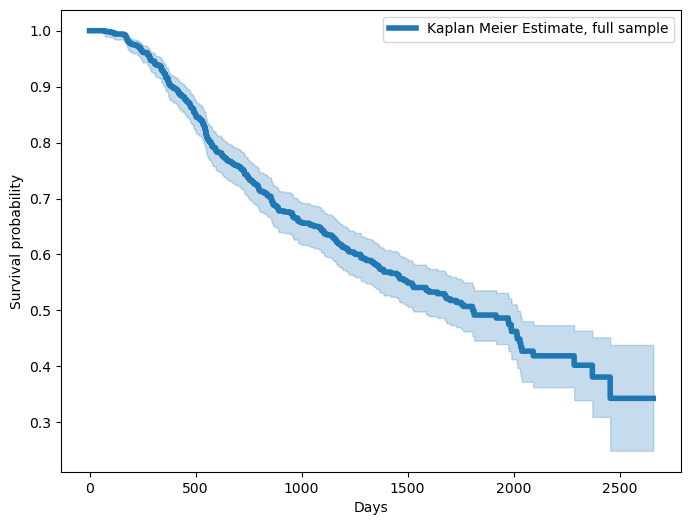

In [242]:
kmf = KaplanMeierFitter() 
kmf.fit(df.time, df.cens, label = 'Kaplan Meier Estimate, full sample')
kmf.plot(linewidth=4, figsize=(8, 6))
plt.xlabel('Days')
plt.ylabel('Survival probability')

print("Median survival time in days:", kmf.median_survival_time_)

We can see how the survival probability varies with time. Here, I haven't separated out the data depending on whether there was hormonal therapy or not. I will do more extensive analysis next.

# Section 3: Exploring the impact of the main predictor

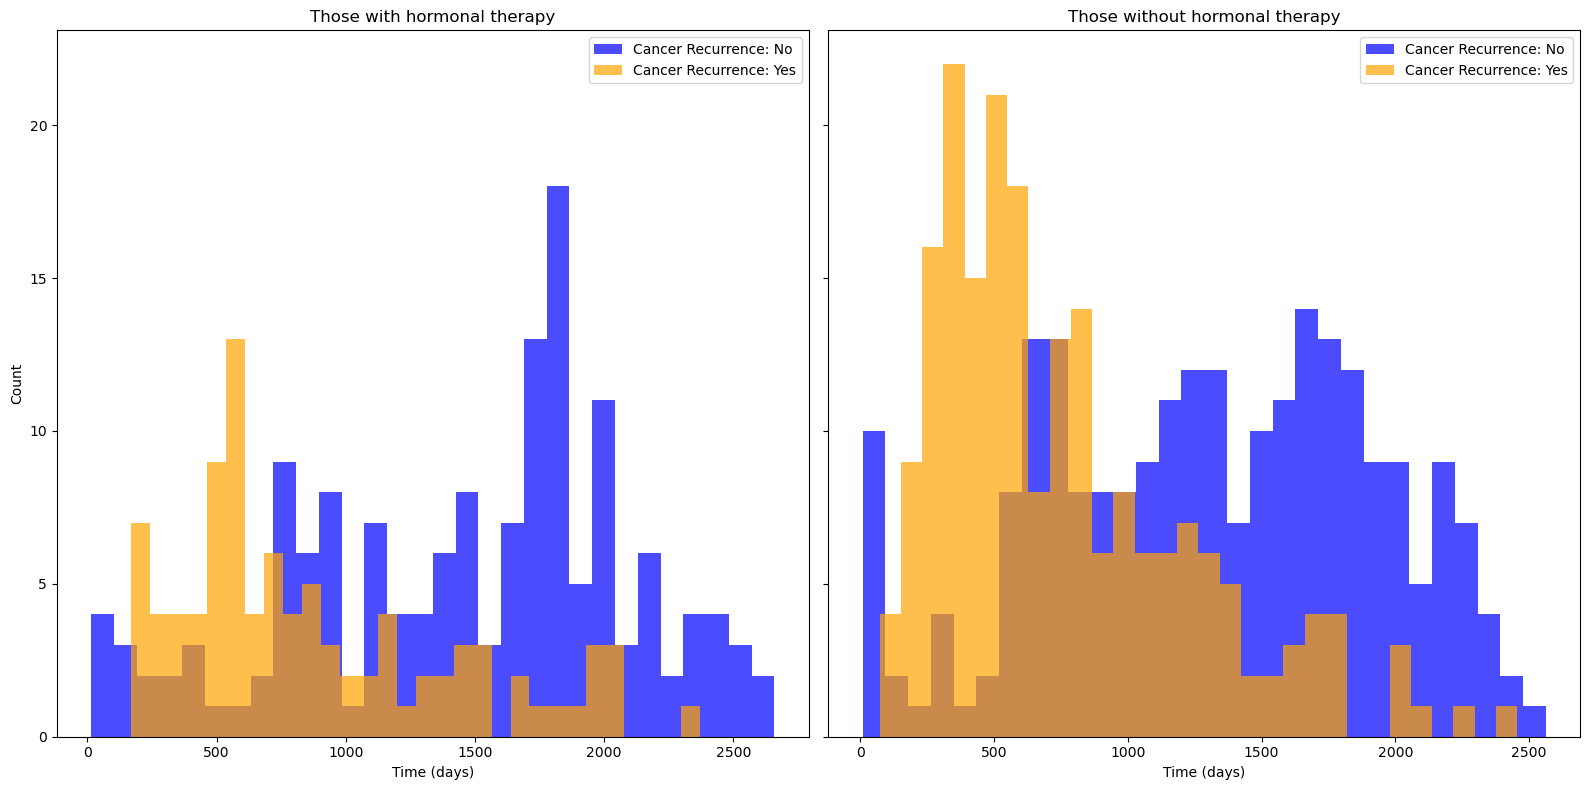

In [244]:
# Impact of hormonal therapy using histograms 

colors = {0: 'blue', 1: 'orange'}

df1 = df[df['horTh'] == 'yes']
df2 = df[df['horTh'] == 'no']

fig, ax = plt.subplots(1, 2, figsize=(16, 8), sharey=True)

# Plot for those with hormonal therapy
for cens_val, group in df1.groupby('cens'):
    group['time'].plot(kind='hist', bins=30, alpha=0.7, ax=ax[0], 
                       color=colors[cens_val], 
                       label=f"Cancer Recurrence: {'Yes' if cens_val == 1 else 'No'}")
ax[0].set_title('Those with hormonal therapy')
ax[0].set_xlabel('Time (days)')
ax[0].set_ylabel('Count')
ax[0].legend()

# Plot for those without hormonal therapy
for cens_val, group in df2.groupby('cens'):
    group['time'].plot(kind='hist', bins=30, alpha=0.7, ax=ax[1], 
                       color=colors[cens_val], 
                       label=f"Cancer Recurrence: {'Yes' if cens_val == 1 else 'No'}")
ax[1].set_title('Those without hormonal therapy')
ax[1].set_xlabel('Time (days)')
ax[1].legend()

plt.tight_layout()
plt.show()


The effect of the main predictor hormonal therapy is not very clear just from the above plot. Next I will plot the Kaplan-Meier curves separately for the samples with and without hormonal therapy. 

Text(0, 0.5, 'Survival probability')

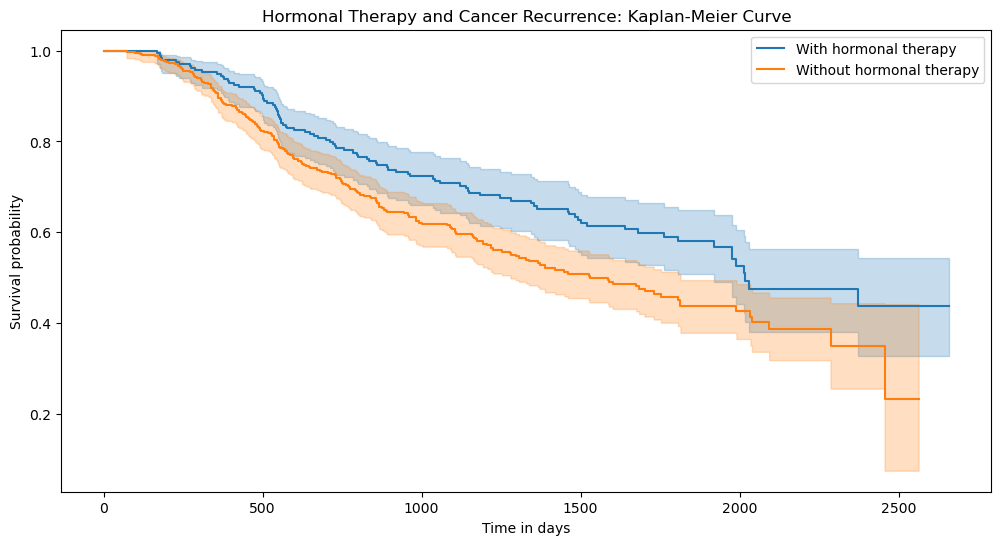

In [246]:
kmf.fit(df1.time, df1.cens)
kmf.plot(label='With hormonal therapy', figsize=(12, 6))
kmf.fit(df2.time, df2.cens)
kmf.plot(label='Without hormonal therapy')
plt.title('Hormonal Therapy and Cancer Recurrence: Kaplan-Meier Curve')
plt.xlabel('Time in days')
plt.ylabel('Survival probability')

Hormonal therapy increases the survival chances, although the difference may not be statistically significant. Nevertheless, I will do additional analysis, also exploring the effect of confounders to make final conclusions. 

# Section 4: Cox Proportional Hazards Model 

Next I will do a survival regression using this model, which assumes each predictor to have proportional (time-independent) effects on the hazard rate. More details, such as possible improvements to the assumptions, can be found in the [lifelines](https://lifelines.readthedocs.io/en/latest/) module. 

In [330]:
# Setting up the data
dfu = df[['horTh', 'cens']]
dfd = pd.get_dummies(dfu, drop_first=True)
dfd['time'] = df.time 

     cens  horTh_yes  time
0       1      False  1814
1       1       True  2018
2       1       True   712
3       1       True  1807
4       1      False   772
..    ...        ...   ...
681     0      False   721
682     0       True   186
683     1      False   769
684     1      False   727
685     1      False  1701

[686 rows x 3 columns]


I will make the variable name more informative and then do the regression. 

<lifelines.CoxPHFitter: fitted with 686 total observations, 387 right-censored observations>
             duration col = 'time'
                event col = 'cens'
      baseline estimation = breslow
   number of observations = 686
number of events observed = 299
   partial log-likelihood = -1783.69
         time fit was run = 2024-12-19 19:18:20 UTC

---
                       coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                              
With Hormonal Therapy -0.36      0.69      0.13           -0.61           -0.12                0.54                0.89

                       cmp to     z      p  -log2(p)
covariate                                           
With Hormonal Therapy    0.00 -2.91 <0.005      8.12
---
Concordance = 0.54
Partial AIC = 3569.39
log-likelihood ratio test = 8.82 on 1 df
-log2(p) of ll-ratio test = 8.39



<Axes: xlabel='log(HR) (95% CI)'>

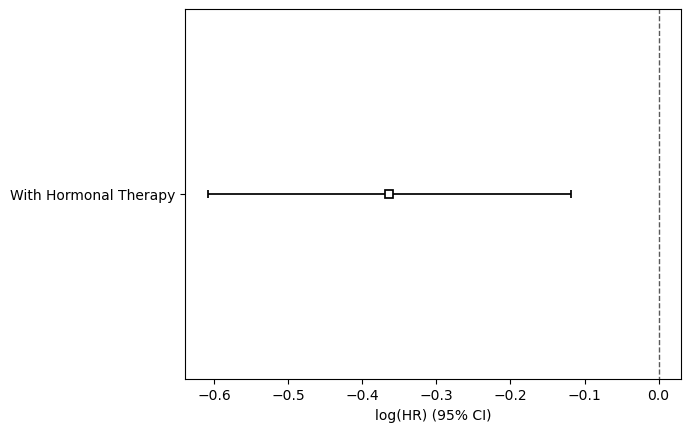

In [279]:
dfd.rename(columns={'horTh_yes': 'With Hormonal Therapy'}, inplace=True)
cph = CoxPHFitter()
cph.fit(dfd, duration_col='time', event_col='cens')
cph.print_summary(style='ascii')
cph.plot()

We see that hormonal therapy has a significant negative effect on the log hazard ratio. In other words, high survival chances for those who underwent hormonal therapy. (Although this is consistent with Kaplan-Meier curve, the statistical significance was not evident there because the CIs showed some overlap.) We can visualize these results using the below command, which produce survival chances with time plots, similar to the Kaplan-Meier curve, but without the confidence bands.  

<Axes: >

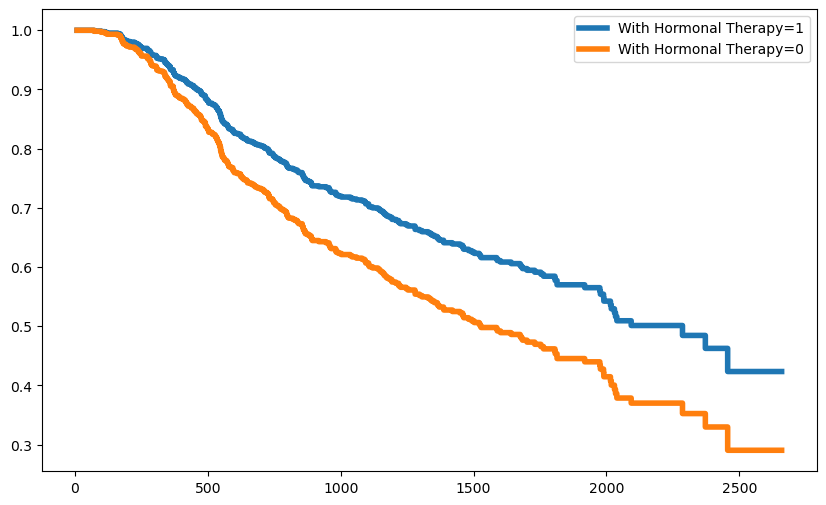

In [294]:
cph.plot_covariate_groups('With Hormonal Therapy', [1,0], plot_baseline=False, figsize=(10, 6), lw=4)

Next I will look at the impact of confounding factors. Except the 'cens' column (incicating whether the event is censored or not) which will be used as the event column in the Cox regression, I have 9 predictors. Three of these (i.e., hormonal therapy status, tumor grade, menopausal status) are categorical. One of them (tumor grade) has three levels, whereas the rest have two levels each. So, overall there are $6+2*1+1*2 = 10$ variables in the regression. Given that the sample size is 686, I can include all the predictors together without compromising statistical power. 

Note: Ideally one should also a correlation analysis to ensure that only independent predictors are included in the analysis. We will see a possible consequence of this at the end.

In [332]:
dfd = pd.get_dummies(df, drop_first=True)
dfd.rename(columns={'horTh_yes': 'With Hormonal Therapy'}, inplace=True)
dfd.rename(columns={'menostat_Pre': 'Pre-menopause'}, inplace=True)
dfd.rename(columns={'tgrade_II':'Tumor grade II'}, inplace=True)
dfd.rename(columns={'tgrade_III':'Tumor grade III'}, inplace=True)
print(dfd.tail(10))

     age  tsize  pnodes  progrec  estrec  time  cens  With Hormonal Therapy  \
676   56     42       5      113     700   662     1                   True   
677   46     32       1      108      52   969     0                  False   
678   61     27       5      141     346   974     0                   True   
679   40     40       6      227      10   866     1                  False   
680   60     40       6        8      11   504     1                   True   
681   49     30       3        1      84   721     0                  False   
682   53     25      17        0       0   186     0                   True   
683   51     25       5       43       0   769     1                  False   
684   52     23       3       15      34   727     1                  False   
685   55     23       9      116      15  1701     1                  False   

     Pre-menopause  Tumor grade II  Tumor grade III  
676          False           False            False  
677           True    

<lifelines.CoxPHFitter: fitted with 686 total observations, 387 right-censored observations>
             duration col = 'time'
                event col = 'cens'
      baseline estimation = breslow
   number of observations = 686
number of events observed = 299
   partial log-likelihood = -1735.73
         time fit was run = 2024-12-20 14:24:27 UTC

---
                       coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                              
age                   -0.01      0.99      0.01           -0.03            0.01                0.97                1.01
tsize                  0.01      1.01      0.00            0.00            0.02                1.00                1.02
pnodes                 0.05      1.05      0.01            0.03            0.06                1.03                1.07
progrec               -0.00      1.00      

<Axes: xlabel='log(HR) (95% CI)'>

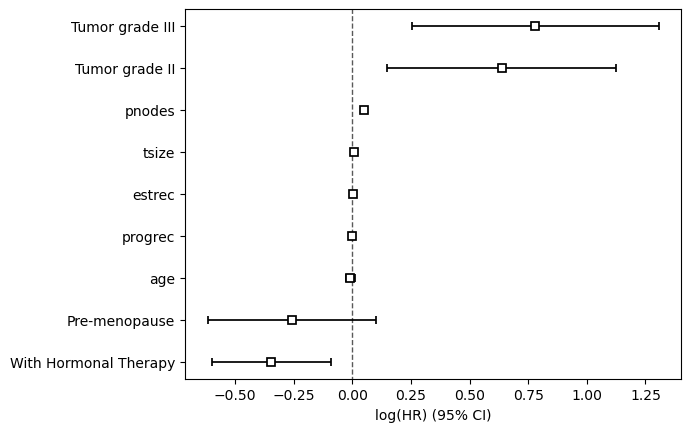

In [334]:
cph = CoxPHFitter()
cph.fit(dfd, duration_col='time', event_col='cens')
cph.print_summary(style='ascii')
cph.plot()

# Main findings

We see that **hormonal treatment increases survival chances significantly**, even when all other predictors are included. Thus we can be more confident that hormonal treatment has a positive impact on increasing the cancer-free survival time. Another observation from here is that tumor grades II or III and the number of positive nodes (the predictor titled "pnodes") decrease survival chances significantly.   

# Next steps 

Note that the confidence intervals (CIs) for the categorical variables are much larger compared to the continuous ones. One reason for this is that the some of the predictors could be strongly correlated with each other. A correlation analysis to select only the independent variables to be included in the regression is therefore a recommended step. Another way to overcome this situation is by standardizing (dividing the variable by the standard deviation after subtracting the mean from it).  

Some of the variables could also involve an interaction between them. For example, a hypothetical scenario is that there may not be any difference in cancer recurrence chances between younger and older individuals for tumor grade I, whereas the recurrence risk increases with age for tumor grades II and III. A more thorough analysis could involve incorporation on these aspects, also based on scientific evidence on how breast cancer outcomes could be influenced by various factors and their interactions.   

## More on the correlation analysis

Depending on the variables are categorical or continuous, the statistical test for correlation analysis needs to be different. The test will be different also based on the distributions of the continuous variables. [Here](https://www.lancaster.ac.uk/stor-i-student-sites/ziyang-yang/2021/02/26/statistics-in-social-science-1-how-to-choose-an-appropriate-statistical-test/) is a simple read on this, but the assumptions can be more [involved](https://www.statisticssolutions.com/free-resources/directory-of-statistical-analyses/correlation-pearson-kendall-spearman/). As an easy approach, all continuous variables could be transformed so as to approximate them as normal distributions only for the purpose of the correlation analysis. 

# The end